# Esquema del modelo definitivo

## I. Librerias y funciones

In [2]:
#Librerias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
from lazypredict.Supervised import LazyRegressor

In [3]:
# Función para convertir los datos en secuencias de tiempo
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    # Ajuste para asegurarse de que no excedamos el rango del conjunto de datos
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


## II. Procesado del DF

In [45]:
print(os.getcwd())

c:\Users\minip\OneDrive - Universidad de Málaga\Documentos\4Geek\Proyecto final\AMH-proyecto-final\src\Proceso de modelos


In [46]:
print(os.path.exists('../data/DF_modelos/df_industrial_total.csv'))

False


In [4]:
#Covid transofromar en niveles de restricciones
df = pd.read_csv(r'C:/Users/minip/OneDrive - Universidad de Málaga/Documentos/4Geek/Proyecto final/AMH-proyecto-final/data/DF_modelos/df_industrial_total.csv')
df = df.drop(columns=['Sector_Economic','año','poblacion','velmedia','prec','Empleo','PIB','lectivos'])  

In [5]:
#Analizar los valores de df
df

,consumo,fecha,findesemana,festivos,COVID,tmed
0,995989,2019-01-01,0,1,0,8.59
1,1702091,2019-01-02,0,0,0,6.62
2,1826076,2019-01-03,0,0,0,5.60
3,1806926,2019-01-04,0,0,0,5.00
4,1341548,2019-01-05,1,0,0,6.17
...,...,...,...,...,...,...
2003,1403736,2024-06-26,0,0,0,22.62
2004,1365435,2024-06-27,0,0,0,23.78
2005,1358576,2024-06-28,0,0,0,24.45
2006,994740,2024-06-29,1,0,0,20.94


In [6]:
#Eliminar consumos anomalos
index_primera_menor_1000 = df[df['consumo'] < 1000].index.min()

# Eliminar todas las filas desde ese índice en adelante
if index_primera_menor_1000 is not None:
    df = df.loc[:index_primera_menor_1000-1]

df

,consumo,fecha,findesemana,festivos,COVID,tmed
0,995989,2019-01-01,0,1,0,8.59
1,1702091,2019-01-02,0,0,0,6.62
2,1826076,2019-01-03,0,0,0,5.60
3,1806926,2019-01-04,0,0,0,5.00
4,1341548,2019-01-05,1,0,0,6.17
...,...,...,...,...,...,...
1943,799363,2024-04-27,1,0,0,14.11
1944,749970,2024-04-28,1,0,0,12.46
1945,1066271,2024-04-29,0,0,0,11.62
1946,1076872,2024-04-30,0,0,0,13.54


In [7]:
#Consumo previo 3 dias
df['t-1'] = df['consumo'].shift(1)
df['t-2'] = df['consumo'].shift(2)
df['t-3'] = df['consumo'].shift(3)

In [8]:
#Eliminar filas con valores nulos
df.dropna(inplace=True)
df = df.reset_index(drop=True)
df

,consumo,fecha,findesemana,festivos,COVID,tmed,t-1,t-2,t-3
0,1806926,2019-01-04,0,0,0,5.00,1826076.00,1702091.00,995989.00
1,1341548,2019-01-05,1,0,0,6.17,1806926.00,1826076.00,1702091.00
2,1201714,2019-01-06,1,0,0,9.13,1341548.00,1806926.00,1826076.00
3,1921881,2019-01-07,0,0,0,6.93,1201714.00,1341548.00,1806926.00
4,2048335,2019-01-08,0,0,0,4.95,1921881.00,1201714.00,1341548.00
...,...,...,...,...,...,...,...,...,...
1940,799363,2024-04-27,1,0,0,14.11,1076123.00,1093059.00,1054506.00
1941,749970,2024-04-28,1,0,0,12.46,799363.00,1076123.00,1093059.00
1942,1066271,2024-04-29,0,0,0,11.62,749970.00,799363.00,1076123.00
1943,1076872,2024-04-30,0,0,0,13.54,1066271.00,749970.00,799363.00


In [9]:
#Formatear 
df['COVID'].replace(2,3,inplace=True)
df['COVID'].replace(1,2,inplace=True)
df['COVID'].replace(3,1,inplace=True)

In [10]:
df.dtypes

consumo          int64
fecha           object
findesemana      int64
festivos         int64
COVID            int64
tmed           float64
t-1            float64
t-2            float64
t-3            float64
dtype: object

In [11]:
df.nunique()

consumo        1913
fecha          1945
findesemana       2
festivos          2
COVID             3
tmed           1845
t-1            1913
t-2            1913
t-3            1913
dtype: int64

In [12]:
df.shape

(1945, 9)

In [13]:
# Asegúrate de que la columna de fecha está en formato datetime
# Convertir la columna de fecha a formato datetime
df['fecha'] = pd.to_datetime(df['fecha'])
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y')  # Ajusta el formato según tus datos

# Convertir la columna de fecha a timestamp
df['fecha'] = df['fecha'].astype(np.int64) // 10**9  # Convertir a dias

In [14]:
df

,consumo,fecha,findesemana,festivos,COVID,tmed,t-1,t-2,t-3
0,1806926,1546560000,0,0,0,5.00,1826076.00,1702091.00,995989.00
1,1341548,1546646400,1,0,0,6.17,1806926.00,1826076.00,1702091.00
2,1201714,1546732800,1,0,0,9.13,1341548.00,1806926.00,1826076.00
3,1921881,1546819200,0,0,0,6.93,1201714.00,1341548.00,1806926.00
4,2048335,1546905600,0,0,0,4.95,1921881.00,1201714.00,1341548.00
...,...,...,...,...,...,...,...,...,...
1940,799363,1714176000,1,0,0,14.11,1076123.00,1093059.00,1054506.00
1941,749970,1714262400,1,0,0,12.46,799363.00,1076123.00,1093059.00
1942,1066271,1714348800,0,0,0,11.62,749970.00,799363.00,1076123.00
1943,1076872,1714435200,0,0,0,13.54,1066271.00,749970.00,799363.00


## III. Analisis de variables potenciales

In [14]:
# Definir características (X) y objetivo (y)
X = df(columns=['consumo'])  
y = df['consumo']  

test_size_percentage = 0.09
split_index = int(len(X) * (1 - test_size_percentage))

# Dividir en conjunto de entrenamiento (primera parte) y prueba (última parte)
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

In [15]:
#Escalar las variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Modelo para seleccion de caracteristicas importantes
# Definir el modelo XGBoost
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, learning_rate=0.1)

# Entrenar el modelo con los datos de entrenamiento
model_xgb.fit(X_train_scaled, y_train)

# Realizar predicciones con los datos de prueba
y_pred = model_xgb.predict(X_test_scaled)

# Calcular el error cuadrático medio (RMSE) como métrica de evaluación
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Obtener la importancia de las características
importancia = model_xgb.feature_importances_

# Crear un DataFrame para visualizar las importancias
feature_importance = pd.DataFrame({'Variable': X.columns, 'Importancia': importancia*100})
feature_importance = feature_importance.sort_values(by='Importancia', ascending=False)
# Mostrar las variables ordenadas por importancia
print(feature_importance)

C:\Users\minip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 104769.0501597512
      Variable  Importancia
1  findesemana    37.844616
5          t-1    36.166225
2     festivos    10.263535
3        COVID     8.327732
0        fecha     5.259157
4         tmed     2.138731


In [17]:
# convertir de array a pandas para el VIF
df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
df_X_train_selected = df_X_train_scaled[['findesemana', 't-1', 'festivos', 'COVID', 'tmed', 'fecha']]
df_X_train_selected

,findesemana,t-1,festivos,COVID,tmed,fecha
0,-0.632456,-1.337818,-0.196748,-0.629797,-1.391208,-1.731073
1,-0.632456,0.193103,-0.196748,-0.629797,-1.545792,-1.729117
2,-0.632456,0.461918,-0.196748,-0.629797,-1.637348,-1.727161
3,1.581139,0.420398,-0.196748,-0.629797,-1.458879,-1.725205
4,1.581139,-0.588602,-0.196748,-0.629797,-1.007733,-1.723249
...,...,...,...,...,...,...
1766,-0.632456,-1.423132,-0.196748,-0.629797,-0.601038,1.723249
1767,1.581139,-1.355940,-0.196748,-0.629797,-0.363522,1.725205
1768,1.581139,-1.929540,-0.196748,-0.629797,-0.266659,1.727161
1769,-0.632456,-2.105375,-0.196748,-0.629797,-0.523414,1.729117


In [18]:
#Test VIF
vif = pd.Series([variance_inflation_factor(df_X_train_selected.corr().values, i) for i in range(df_X_train_selected.corr().shape[1])], index=df_X_train_selected.columns)
vif

findesemana    1.111830
t-1            2.913607
festivos       1.079916
COVID          1.797220
tmed           1.284506
fecha          3.385639
dtype: float64

## IV. Modelo LSTM

### IV.I. Preparar datos

In [15]:
#Ordenar los datos cronologicamnte
df = df.sort_values(by='fecha')

In [34]:
# Definir características (X) y objetivo (y)
X = df[['t-1']]
y = np.log(df['consumo'])

In [35]:
# Dividir en conjunto de entrenamiento y prueba (manteniendo el orden temporal)
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [36]:
X_train

,t-1
0,1826076.00
1,1806926.00
2,1341548.00
3,1201714.00
4,1921881.00
...,...
1745,844189.00
1746,761268.00
1747,1117010.00
1748,1215964.00


In [29]:
X_test

,t-1,t-2,t-3
1750,1117176.00,1228537.00,1215964.00
1751,994555.00,1117176.00,1228537.00
1752,677477.00,994555.00,1117176.00
1753,592567.00,677477.00,994555.00
1754,986630.00,592567.00,677477.00
...,...,...,...
1940,1076123.00,1093059.00,1054506.00
1941,799363.00,1076123.00,1093059.00
1942,749970.00,799363.00,1076123.00
1943,1066271.00,749970.00,799363.00


In [37]:
y_train

0      14.41
1      14.11
2      14.00
3      14.47
4      14.53
        ... 
1745   13.54
1746   13.93
1747   14.01
1748   14.02
1749   13.93
Name: consumo, Length: 1750, dtype: float64

In [22]:
y_test

1750     994555
1751     677477
1752     592567
1753     986630
1754     971368
         ...   
1940     799363
1941     749970
1942    1066271
1943    1076872
1944     741119
Name: consumo, Length: 195, dtype: int64

In [77]:
#El escalado es posterior a la dividimos en train y test
# Escalar los datos con MinMaxScaler (LSTM es sensible a la escala de los datos)
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)

X_test_scaled = scaler_X.transform(X_test)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [38]:
# Escalar los datos con MinMaxScaler (LSTM es sensible a la escala de los datos)
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [39]:
#Lazy predidt
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train_scaled, X_test_scaled, y_train, y_test)

100%|██████████| 42/42 [00:03<00:00, 11.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1750, number of used features: 1
[LightGBM] [Info] Start training from score 14.261849


In [40]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RANSACRegressor,0.18,0.18,0.21,0.01
AdaBoostRegressor,-0.46,-0.45,0.28,0.06
LinearSVR,-0.54,-0.53,0.28,0.01
GradientBoostingRegressor,-0.54,-0.53,0.28,0.21
LGBMRegressor,-0.55,-0.54,0.28,0.04
HistGradientBoostingRegressor,-0.56,-0.55,0.29,0.26
KNeighborsRegressor,-0.58,-0.57,0.29,0.01
SVR,-0.58,-0.57,0.29,0.09
NuSVR,-0.59,-0.58,0.29,0.14


In [78]:
# Crear secuencias de tiempo para LSTM
time_steps = 3  # Esto significa que la predicción se basará en los últimos 10 días
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
print(f"Forma de X_train_seq: {X_train_seq.shape}")  # Debe ser (samples, time_steps, features)

KeyError: 3

In [74]:
X_train_seq

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.61739130e+00,
         9.95989000e+05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.60434783e+00,
         1.70209100e+06],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.00434783e+00,
         1.82607600e+06]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.60434783e+00,
         1.70209100e+06],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.00434783e+00,
         1.82607600e+06],
        [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.17391304e+00,
         1.80692600e+06]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.00434783e+00,
         1.82607600e+06],
        [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.17391304e+00,
         1.80692600e+06],
        [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.13043478e+00,
         1.34154800e+06]],

       ...,

       [[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.06521739e+01,
         1.049365

### IV.II. Definir modelo LSTM

In [26]:
# Definir el modelo LSTM
model = Sequential()

In [27]:
# Primera capa LSTM con 50 unidades y dropout para regularización
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))
# Segunda capa LSTM
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
# Capa de salida para la predicción continua de la demanda de electricidad
model.add(Dense(1))

C:\Users\minip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
# Mostrar el resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

### IV.III Entrenamiento del Modelo

In [30]:
# Entrenamiento conm 100 epocas
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_data=(X_test_seq, y_test_seq))

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0463 - val_loss: 0.0162
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132 - val_loss: 0.0061
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0125 - val_loss: 0.0082
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0070
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0042
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0040
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0071
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0052
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0054
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0050
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

### IV.IV. Evaluacion del Modelo

In [31]:
# Evaluar el modelo en el conjunto de prueba
loss = model.evaluate(X_test_seq, y_test_seq)
print(f'Loss: {loss}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014     
Loss: 0.0015214027371257544


In [32]:
#Comprobar la prediccion
# Predecir los valores de prueba
y_pred_scaled = model.predict(X_test_seq)
# Desescalar las predicciones y los valores reales para comparar
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test_seq)
# Comparar las primeras predicciones con los valores reales
print(f"Predicciones: {y_pred[:5].flatten()}")
print(f"Valores reales: {y_test_true[:5].flatten()}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicciones: [903984.75 887928.5  868472.1  880901.2  833856.5 ]
Valores reales: [876720. 958533. 649894. 956640. 987631.]


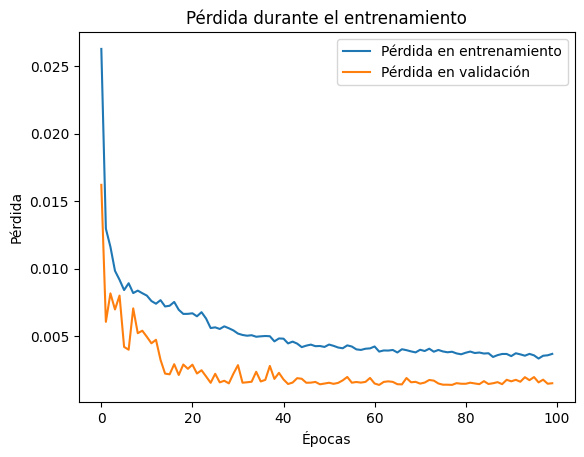

In [33]:
# Visualizar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

## V. Guardar modelo no vaya a ser que se nos borre 

In [34]:
#Extraccion del modelo en la carpeta modelos
model.save('../models/modelo_industrial_Def.h5')